<a id="0"></a>
1. [Ansatz](#1)
2. [Training](#2)
3. [Training for more complicated function](#3)

<a id="1"></a>
## Ansatz
Here we slightly modify the model. The system is in exactly the same form as proposed in the article [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605).

(<Figure size 600x200 with 1 Axes>, <Axes: >)

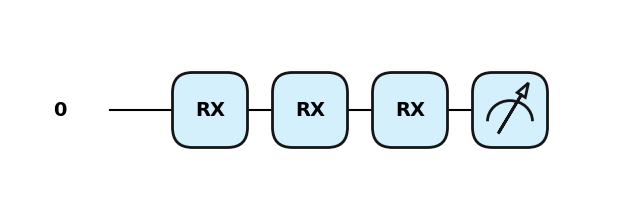

In [1]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def quantum_circuit(x,weights):
    # W(θ)
    qml.RX(weights[0], wires=0)
    # S(x)
    qml.RX(x, wires=[0])
    # W(θ)
    qml.RX(weights[1], wires=0)
    return qml.expval(qml.PauliZ(wires=0))


weights = [0.2,0.3]
x_input = [0.2]
quantum_circuit(x_input,weights)
qml.draw_mpl(quantum_circuit,style='pennylane')(x_input,weights)

<a id="2"></a>
## Training

In [ ]:
def compute_predictions(X, params):
    return [quantum_circuit([x], params) for x in X]

def cost_MSE(params, X, Y):
    predictions = compute_predictions(X,params)
    # mean_squared_error
    cost = np.mean((Y - np.stack(predictions)) ** 2)
    return cost

def training(num_epochs, opt, cost_fn, params, X, Y):
    costs = []
    for epoch in range(num_epochs):
        [params,_,_], prev_cost = opt.step_and_cost(cost_fn,params,X,Y)

        current_cost = cost_fn(params, X, Y)
        costs.append(current_cost)

        print(f"Epoch: {epoch} | Cost: {current_cost:0.7f}")

    print('Final parameters: ',params)
    return params,costs


In [ ]:
import pennylane as qml
import pennylane.numpy as np
from modules.utils import create_data_sin_function

X_train, Y_train, X_test, Y_test = create_data_sin_function(1000)

num_epochs = 30
opt = qml.GradientDescentOptimizer(stepsize=0.1)
init_params = np.array([0.1, 0.1], requires_grad=True)
final_params,costs = training(num_epochs, opt, cost_MSE,init_params, X_train, Y_train)

Both training processes utilize the same training dataset consisting of 800 samples. The number of epochs, optimizer, learning step size, and parameter initialization were conducted in an identical manner for both experiments.
By maintaining the same training data and hyperparameters, we want to conduct a comparison of the two circuits.

* Both training processes show a decreasing trend in the cost values over the 30 epochs.
* The cost values in both logs decrease significantly, indicating that the training process is effectively minimizing the cost function.
* Final Cost Values:
    - previous circuit (Circuit 1) training process ends with a final cost of 0.0000065
    - above circuit (Circuit 2) training process ends with a final cost of 0.0000060
* Metrics:
    - mean Cost (Circuit 1): 0.12396128333333335
    - mean Cost (Circuit 2): 0.12861971333333333
    - standard deviation of Cost (Circuit 1): 0.25247594098020126
    - standard Deviation of Cost (Circuit 2): 0.2532554523253833
* Final parameters:
    - Circuit 1 parameters are [-0.78357105, -0.78357105]
    - Circuit 2 parameters are [-0.78366153, -0.78366153]
    - the absolute differences between the corresponding parameters of the two circuits are [9.048e-5, 9.048e-5]

The analysis shows that both quantum circuits have successfully learned the sine function. The mean cost and standard deviation of cost are similar for both circuits, indicating they perform equally well and train stably. The tiny differences between the final parameters suggest that both circuits ended up with nearly the same solution


In [ ]:
from modules.utils import plot_result

test_cost = cost_MSE(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = compute_predictions(X_test, final_params)

plot_result(X_test,Y_test, test_predictions,X_train,Y_train)

Similar to the previous model, we achieved excellent fitting accuracy.
Unfortunately, our model is only capable of learning a sine function. If we apply it to a more complex function, the model will fail.
Additional explanation can be found in the previous file and in the article [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605).

<a id="3"></a>
## Training for more complicated function


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample signal
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time array
f1, f2, f3 = 50, 120, 300  # Frequencies of the sine waves
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.sin(2 * np.pi * f3 * t)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(t, signal, color='black', label='Complex Function')
plt.title('Complex Sinusoidal Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Compute the Fourier Transform
spectrum = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(spectrum), 1/fs)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:fs//2], np.abs(spectrum)[:fs//2])  # Plot only the positive frequencies
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()